In [156]:
import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras import optimizers

from IPython.display import clear_output
import matplotlib.pyplot as plt

#import pydot as pyd
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

In [209]:
input_length = 10
X_orig = np.loadtxt('10HX.txt')
Y_orig = np.loadtxt('10HY.txt')

#n = len(X)
permutation = np.random.permutation(n)
X_orig = X_orig[permutation]
Y_orig = Y_orig[permutation]

print('Shortened data set')
X = X_orig[:5000]
Y = Y_orig[:5000]

sorted_notes = np.unique(Y)

n_notes_X_orig = len(np.unique(X_orig))
n_notes_Y_orig = len(np.unique(Y_orig))
n_notes_X = len(np.unique(X))
n_notes_Y = n_hidden_units = len(sorted_notes)
max_note = np.max(Y)
min_note = np.min(Y)

X_unnormalized = np.copy(X)
X = X / max_note #normalize input

for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)

print('Make sure these numbers are the same: X_orig={}, Y_orig={}, X={}, Y={}'.format(n_notes_X_orig, n_notes_Y_orig, n_notes_X, n_notes_Y))
print('Number of different notes (hidden units): {}'.format(number_of_different_notes))
print('Shape of X: {}'.format(X.shape))
print('Max: {}, Min: {}'.format(int(max_note), int(min_note)))

n = X.shape[0]

Shortened data set
Make sure these numbers are the same: X_orig=68, Y_orig=68, X=68, Y=68
Number of different notes (hidden units): 68
Shape of X: (5000, 10)
Max: 101, Min: 29


<BarContainer object of 68 artists>

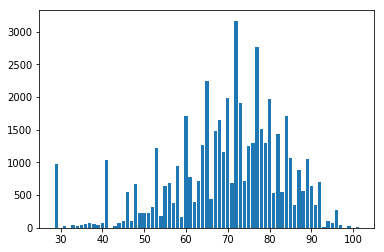

In [210]:
#Plots of note distribution
counts = np.zeros(n_notes_X)
counts_orig = np.zeros(n_notes_X)
for i, note in enumerate(sorted_notes):
    counts[i] = np.sum(X_unnormalized == note)
    counts_orig[i] = np.sum(X_orig == note)
plt.bar(sorted_notes, counts)

<BarContainer object of 68 artists>

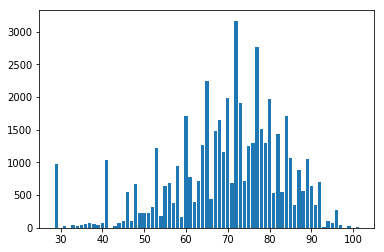

In [211]:
plt.bar(sorted_notes, counts_orig)

In [178]:
model = Sequential()
model.add(LSTM(
    256,
    input_shape=((input_length,1)),
    return_sequences=True
))
model.add(LSTM(n_hidden_units, return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(n_hidden_units))
model.add(Activation('softmax'))
rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
model.load_weights('./hijacked_weights/10LSTM256-LSTM-400-0.2227.hdf5')
print(model.summary())

ValueError: Dimension 1 in both shapes must be equal, but are 272 and 276. Shapes are [256,272] and [256,276]. for 'Assign_23' (op: 'Assign') with input shapes: [256,272], [256,276].

In [6]:
class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs['val_acc'])
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.acc, label="acc")
        plt.plot(self.epochs, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();

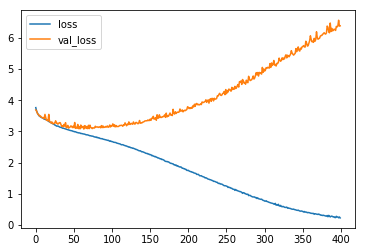

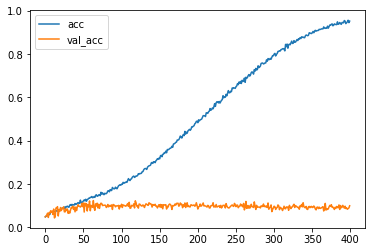

In [9]:
filepath = "./hijacked_weights/10LSTM256-LSTM-{epoch:02d}-{loss:.4f}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()

callbacks_list = [checkpoint, plot]     
fit_data = model.fit(X.reshape(n, input_length, 1), Y, validation_split=0.20,epochs=400, batch_size=64, callbacks=callbacks_list)

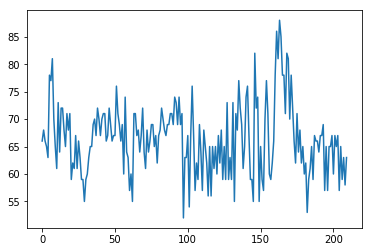

In [158]:
#Generate 200 notes

#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    #print('Input: {}'.format(x))
    prediction = model.predict(x.reshape(1,10,1))
    #print('Prediction: {}'.format(np.argmax(prediction)))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note
plt.plot(predicted_notes)

In [7]:
midi_functions.create_midi_from_notes(predicted_notes, on=250)

(1, 69)


ValueError: x and y must have same first dimension, but have shapes (68,) and (69,)

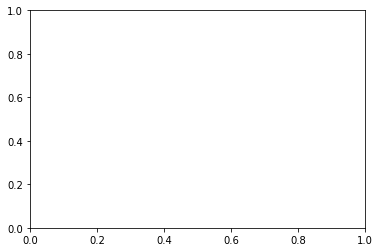

In [171]:
#see what the ouput of softmax looks like
x = X[np.random.randint(0,len(X))]
prediction = model.predict(x.reshape(1,10,1))
print(prediction.shape)
plt.plot(sorted_notes, prediction.reshape(69))
plt.axvline(x=x[9] * max_note)

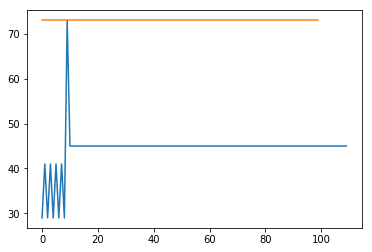

In [213]:
def generate_music_with_bias(bias):
    length = len(bias)
    init = X[np.random.randint(0,len(X))] #Picks out a random training example to begin generation

    predicted_notes = np.zeros(length + input_length)
    predicted_notes[0:input_length] = init
    #predicted_notes[9] = mean / max_note
    
    for note_index, note in enumerate(bias):
        x[0:input_length - 1] = predicted_notes[note_index:note_index + input_length - 1]
        x[input_length - 1] = note / max_note
        prediction = model.predict(x.reshape(1,input_length,1))
        predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
    
    

#Generate 100 notes around a mean
mean = 73

init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(100 + input_length)
predicted_notes[0:input_length] = init
predicted_notes[9] = mean / max_note

for note_index in range(100):
    x = np.zeros(input_length)
    x[0:9] = predicted_notes[note_index:note_index + input_length - 1]
    x[9] = mean / max_note
    #print(x[9] * max_note)
    #print('Input: {}'.format(x))
    prediction = model.predict(x.reshape(1,10,1))
    #print('Prediction: {}'.format(np.argmax(prediction)))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note

plt.plot(predicted_notes)
plt.plot(np.ones(100) * mean)

In [139]:
len(sorted_notes)

68

79 68


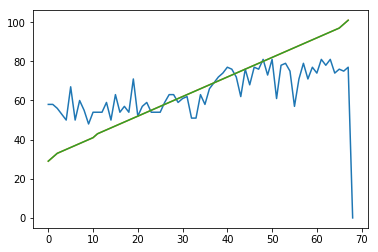

In [175]:
#Generate 100 increasing notes
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(69 + input_length)
predicted_notes[0:input_length] = init
predicted_notes[9] = mean / max_note

hijacked_input = np.zeros(len(sorted_notes))

for note_index in range(len(sorted_notes)):
    x = np.zeros(input_length)
    x[0:9] = predicted_notes[note_index:note_index + input_length - 1]
    x[9] = sorted_notes[note_index] / max_note
    hijacked_input[note_index] = x[9] * max_note
    #print(x[9] * max_note)
    #print('Input: {}'.format(x * max_note))
    prediction = model.predict(x.reshape(1,10,1))
    #print('Prediction: {}'.format(np.argmax(prediction)))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note

#print(predicted_notes)
print(len(predicted_notes), len(sorted_notes))
plt.plot(predicted_notes[10:])
plt.plot(sorted_notes)
plt.plot(hijacked_input)
#plt.plot(np.ones(100) * mean)